# Tutorial 1: Basics


In this tutorial you will learn how to:
* run LightAutoML training on tabular data
* obtain feature importances and reports
* configure resource usage in LightAutoML

Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML)

<img src="../../imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:100%;"/>

## 0. Prerequisites

### 0.0. install LightAutoML

In [1]:
!pip install -U lightautoml

Requirement already up-to-date: lightautoml in /home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages (0.3.2)
You should consider upgrading via the '/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/bin/python -m pip install --upgrade pip' command.


### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [3]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'

In [4]:
DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [6]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [7]:
data = pd.read_csv('../data/sampled_app_train.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [8]:
data.shape

(10000, 122)

### 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [9]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (8000, 122), te_data = (2000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [10]:
task = Task('binary')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [11]:
roles = {
    'target': TARGET_NAME,
    'drop': ['SK_ID_CURR']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="../../imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [12]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [13]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[22:22:25] Stdout logging level is INFO.
[22:22:25] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[22:22:25] Task: binary

[22:22:25] Start automl preset with listed constraints:
[22:22:25] - time: 300.00 seconds
[22:22:25] - CPU: 4 cores
[22:22:25] - memory: 16 GB

[22:22:25] Train data shape: (8000, 122)

[22:22:27] Layer 1 train process start. Time left 298.36 secs
[22:22:27] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:22:29] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7354267797611189
[22:22:29] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:22:29] Time left 295.73 secs

[22:22:31] Selector_LightGBM fitting and predicting completed
[22:22:32] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:22:42] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.736153976493719
[22:22:42] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:22:42] Start hyperparameters optimization for Lvl_0

# 3. Prediction on holdout and model evaluation

In [14]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.06600668],
       [0.0650638 ],
       [0.03359287],
       ...,
       [0.06394241],
       [0.0430077 ],
       [0.18889731]], dtype=float32)
Shape = (2000, 1)
CPU times: user 1.05 s, sys: 4.75 ms, total: 1.06 s
Wall time: 494 ms


In [15]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7524931016763686
HOLDOUT score: 0.733342391304348


# 4. Model analysis

## 4.1. Reports

You can obtain the description of the resulting pipeline:

In [16]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.23540 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.20728 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.13169 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.17945 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.24618 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


Also for this purposes LightAutoML have ReportDeco, use it to build reports:

In [17]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [18]:
%%time
oof_pred = automl_rd.fit_predict(tr_data, roles = roles, verbose = 1)

[22:24:37] Stdout logging level is INFO.
[22:24:37] Task: binary

[22:24:37] Start automl preset with listed constraints:
[22:24:37] - time: 300.00 seconds
[22:24:37] - CPU: 4 cores
[22:24:37] - memory: 16 GB

[22:24:37] Train data shape: (8000, 122)

[22:24:38] Layer 1 train process start. Time left 299.36 secs
[22:24:38] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:24:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7354267797611189
[22:24:40] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:24:40] Time left 296.81 secs

[22:24:42] Selector_LightGBM fitting and predicting completed
[22:24:43] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:24:53] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.736153976493719
[22:24:53] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:24:53] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 24.42 secs
[22:25:19] Hyperparameters optimization for Lvl_0_P

So the report is available in tabularAutoML_model_report folder

In [19]:
!ls tabularAutoML_model_report

feature_importance.png		  valid_pr_curve.png
lama_interactive_report.html	  valid_preds_distribution_by_bins.png
valid_distribution_of_logits.png  valid_roc_curve.png
valid_pie_f1_metric.png


In [20]:
%%time

te_pred = automl_rd.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.06600668],
       [0.0650638 ],
       [0.03359287],
       ...,
       [0.06394241],
       [0.0430077 ],
       [0.18889731]], dtype=float32)
Shape = (2000, 1)
CPU times: user 2.18 s, sys: 76.4 ms, total: 2.25 s
Wall time: 1.73 s


In [21]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7524931016763686
HOLDOUT score: 0.733342391304348


## 4.2 Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 129 ms, sys: 35 µs, total: 129 ms
Wall time: 129 ms


<AxesSubplot:xlabel='Feature'>

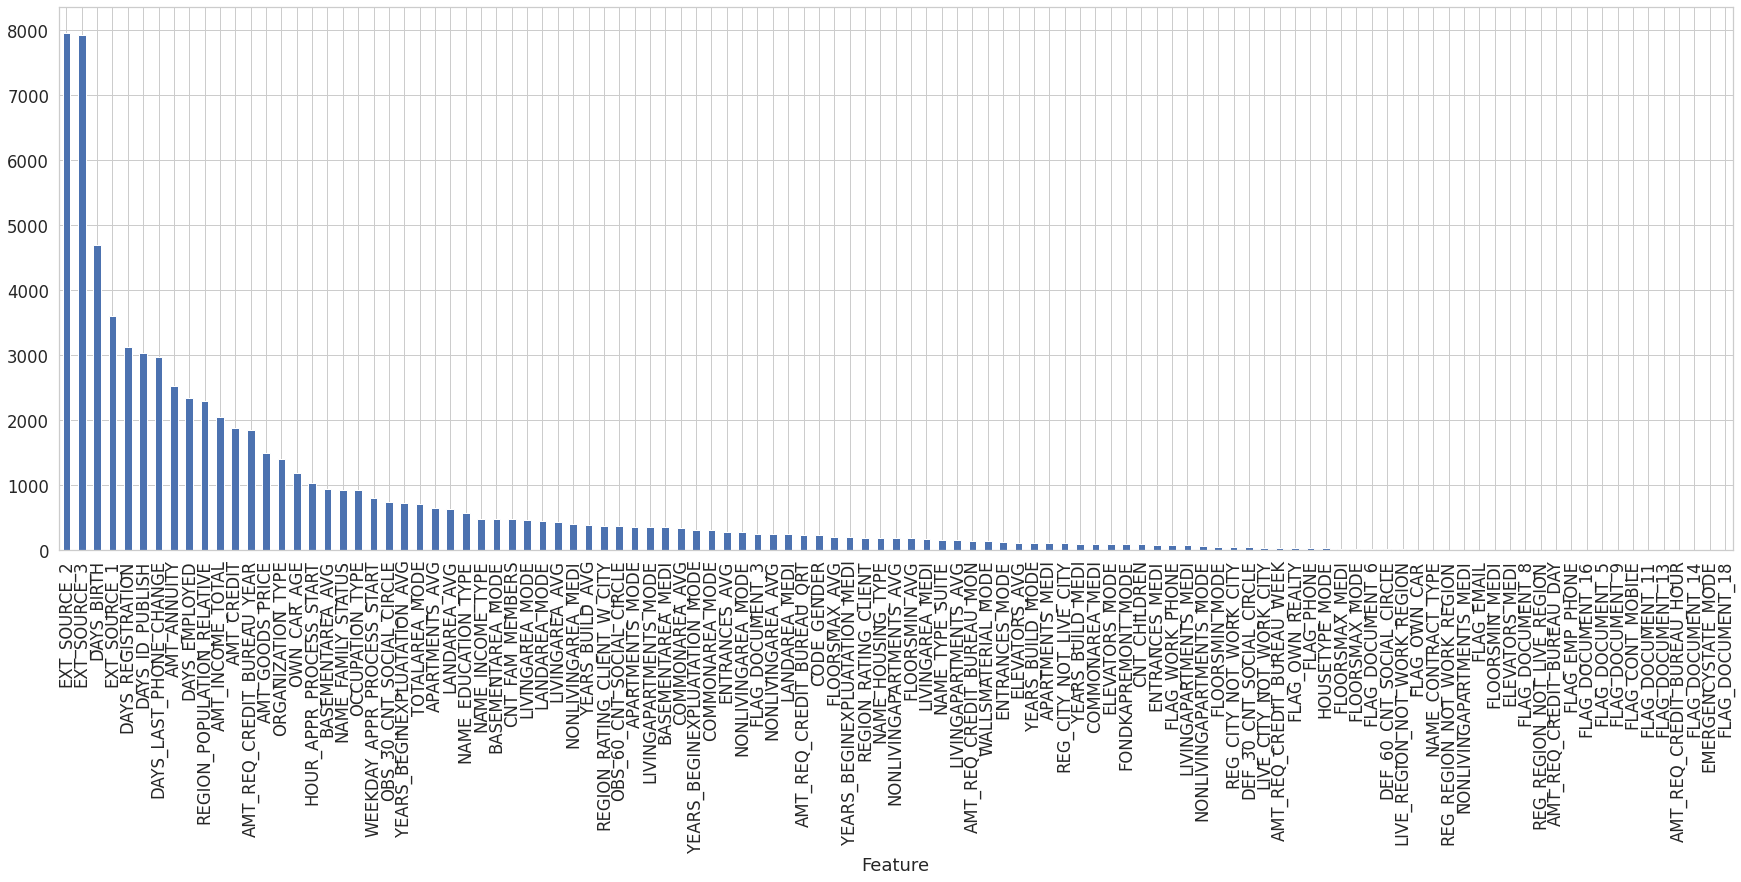

In [22]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [23]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = False)

CPU times: user 1min 55s, sys: 1.66 s, total: 1min 56s
Wall time: 54.6 s


<AxesSubplot:xlabel='Feature'>

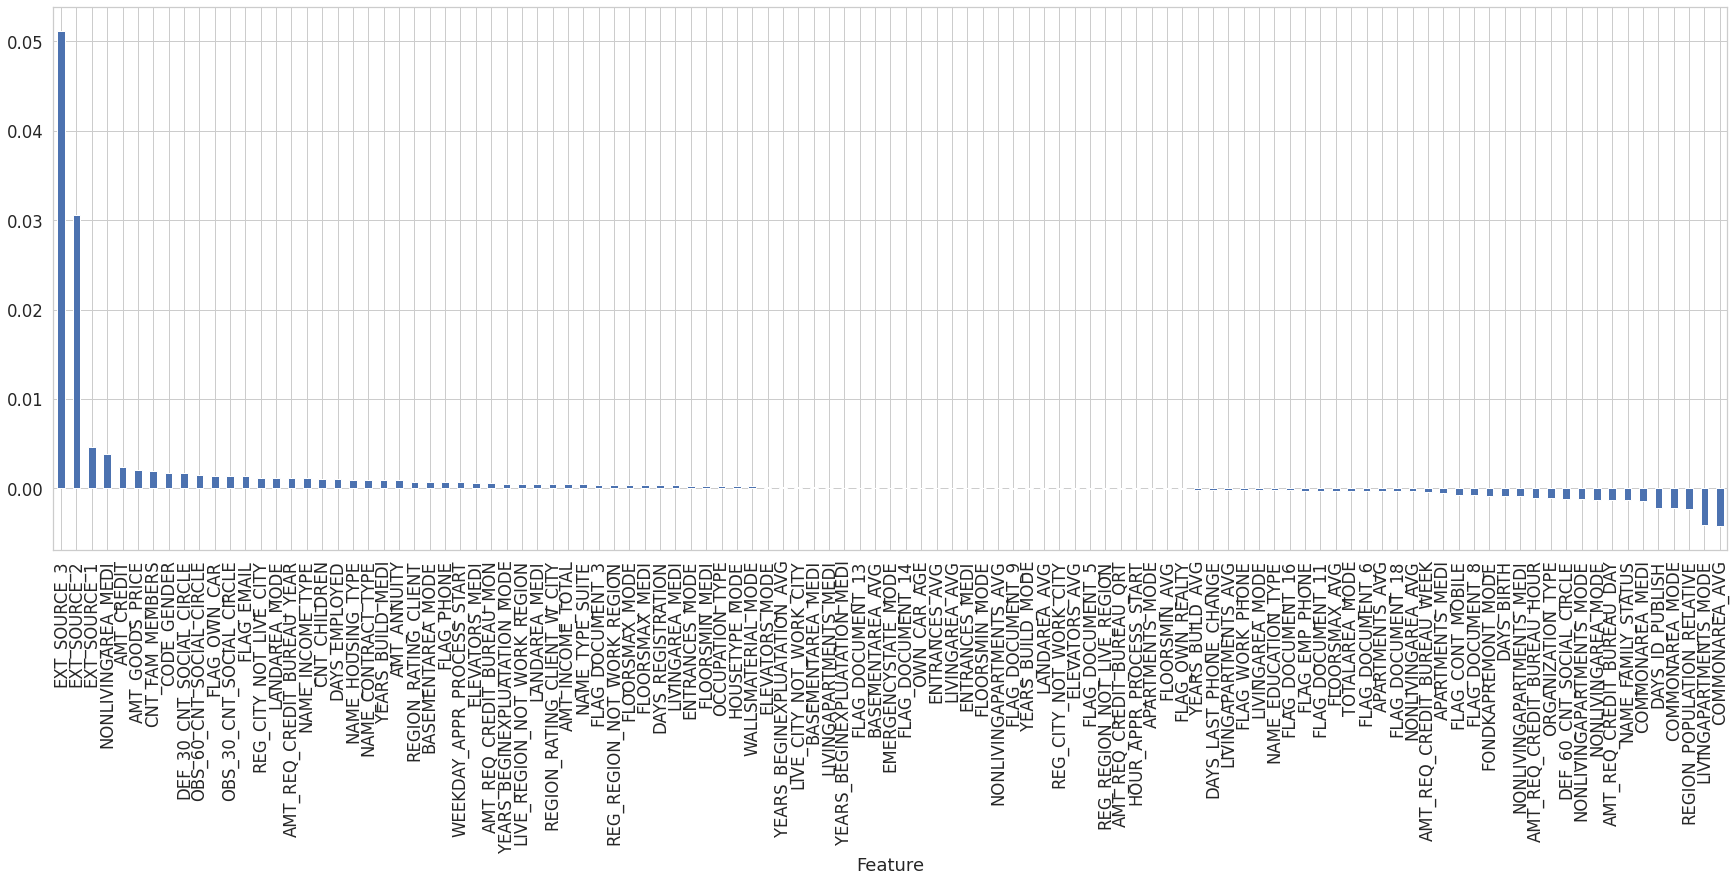

In [24]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

## Bonus: where is the automatic report?

As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output kaggle folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

# 5. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

Using `TabularAutoML` we spent only 31 second to build the model with setup `TIMEOUT` equal to 5 minutes. To spend (almost) all the `TIMEOUT` we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API:

In [25]:
utilized_automl = TabularUtilizedAutoML(
    task = task, 
    timeout = 600,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [26]:
%%time 

oof_pred = utilized_automl.fit_predict(tr_data, roles = roles, verbose = 1)

[22:27:54] Start automl utilizator with listed constraints:
[22:27:54] - time: 600.00 seconds
[22:27:54] - CPU: 4 cores
[22:27:54] - memory: 16 GB

[22:27:54] If one preset completes earlier, next preset configuration will be started

[22:27:54] ==================================================
[22:27:54] Start 0 automl preset configuration:
[22:27:54] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[22:27:54] Stdout logging level is INFO.
[22:27:54] Task: binary

[22:27:54] Start automl preset with listed constraints:
[22:27:54] - time: 600.00 seconds
[22:27:54] - CPU: 4 cores
[22:27:54] - memory: 16 GB

[22:27:54] Train data shape: (8000, 122)

[22:27:55] Layer 1 train process start. Time left 598.90 secs
[22:27:55] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:27:59] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7354267797611189
[22:27:59] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicti

In [27]:
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[0.04592051],
       [0.02179325],
       [0.03530435],
       ...,
       [0.0270937 ],
       [0.20256332],
       [0.12435982]], dtype=float32)
Shape = (8000, 1)


In [28]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	0.76393 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.20253 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.19259 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.19970 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.08863 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.31655 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.23607 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.32276 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.34480 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.06066 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.27178 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost)

Feature importances calculation for `TabularUtilizedAutoML`:

CPU times: user 194 ms, sys: 0 ns, total: 194 ms
Wall time: 191 ms


<AxesSubplot:xlabel='Feature'>

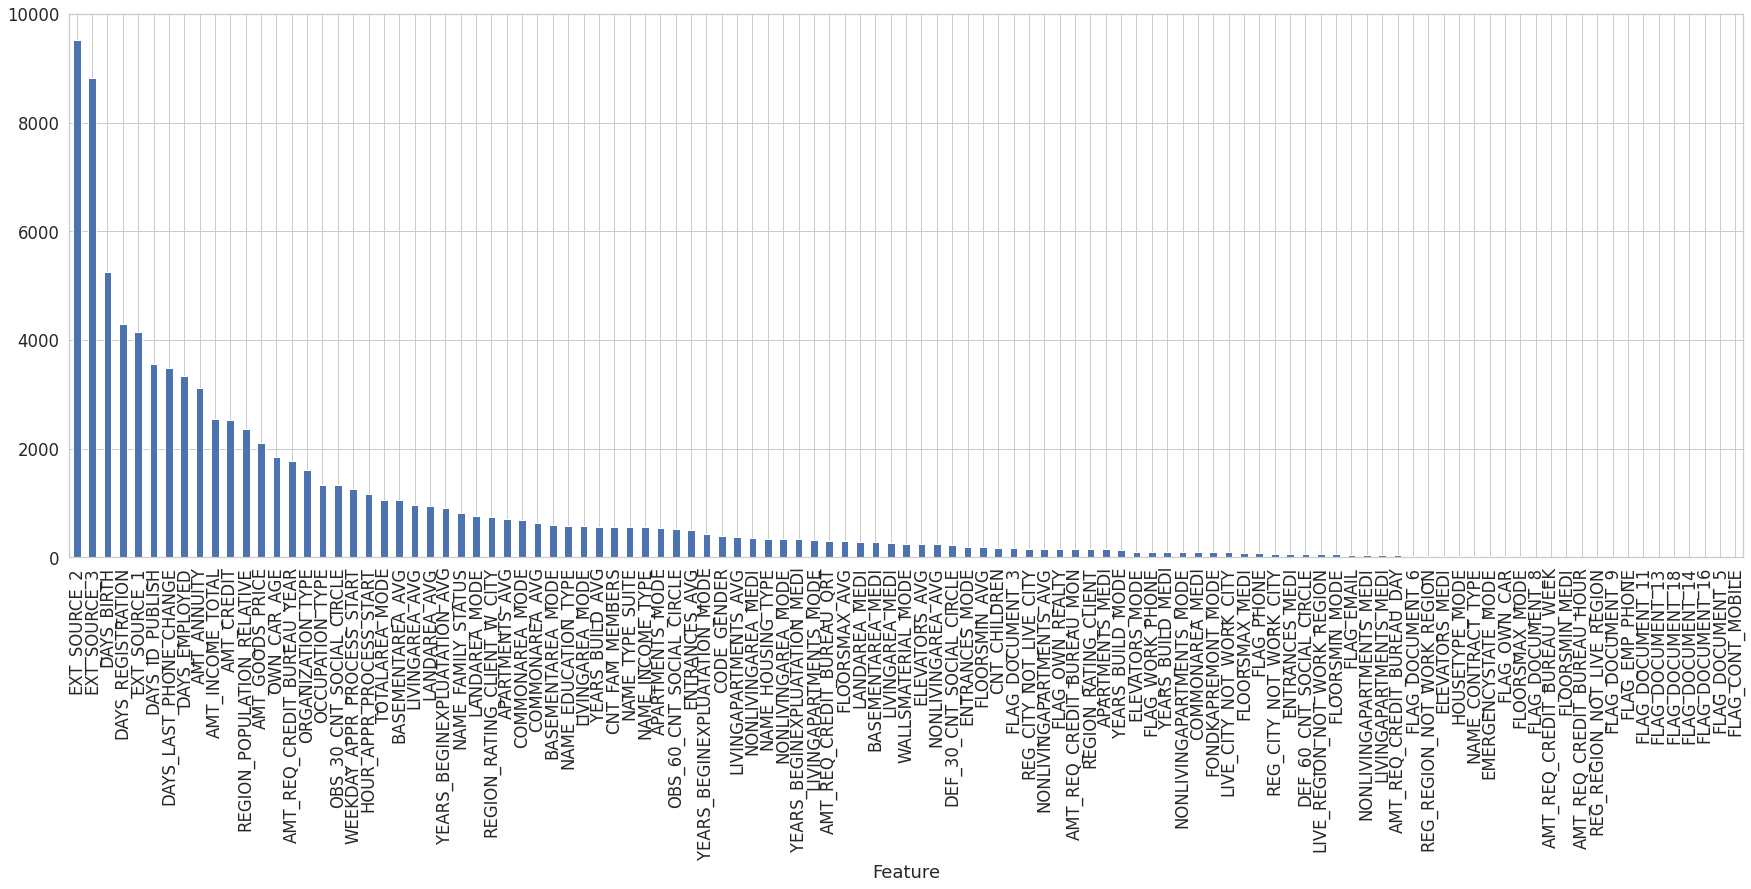

In [29]:
%%time

# Fast feature importances calculation
fast_fi = utilized_automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Prediction on holdout and metric calculation

In [30]:
%%time

te_pred = utilized_automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.06497989],
       [0.07302144],
       [0.03250763],
       ...,
       [0.06503336],
       [0.04197088],
       [0.2061421 ]], dtype=float32)
Shape = (2000, 1)
CPU times: user 2.64 s, sys: 148 ms, total: 2.79 s
Wall time: 1.33 s


In [31]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7524115697521027
HOLDOUT score: 0.7347927989130435


# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)